In [ ]:
import json
import pandas as pd
import numpy as np  
import os
import random

from metric import r_precision, dcg_at_k, ndcg_at_k
from utils import generate_playlists, generate_testcases

from numpy import linalg as LA

import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns
import collections

import lightgbm as lgb

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
path_to_data = '../../data' #'/content/drive/MyDrive/DO_AN_KHDL/DATA'
path_audio_feats = os.path.join(path_to_data, 'audio_features.tsv')
path_playlists = os.path.join(path_to_data, 'playlists.tsv')
path_tracks = os.path.join(path_to_data, 'tracks.tsv')

In [ ]:
pd_audio_feats = pd.read_csv(path_audio_feats, sep = '\t')
pd_tracks = pd.read_csv(path_tracks, sep = '\t')
pd_playlists = pd.read_csv(path_playlists, sep = '\t')
pd_playlists = pd_playlists.fillna('None')

In [ ]:
pd_tracks = pd.merge(pd_tracks, pd_audio_feats, left_on = 'track_id', right_on = 'id')
pd_full = pd.merge(pd_tracks, pd_playlists, left_on = 'playlist_id', right_on = 'playlist_id')

pd_tracks = pd_tracks.drop('id', 1)
pd_full = pd_full.drop('playlist_name_y', 1)
pd_full = pd_full.drop('id', 1)

In [ ]:
pd_full.shape

(86400, 27)

In [ ]:
#Thông tin rỗng là discription, ta có thể chỉ điền vào "None"
pd_full = pd_full.fillna('None')

In [ ]:
#Kiểm tra và bỏ giá trị trùng lặp
pd_full = pd_full.drop_duplicates()

In [ ]:
pd_full['available_markets'] = pd_full['available_markets'].apply(lambda x : x[1:-1].split(', '))
pd_full['count_available_markets'] = pd_full['available_markets'].apply(lambda x : len(x))

In [ ]:
pd_full.shape

(86350, 28)

In [ ]:
pd_full.head()

,track_id,track_name,playlist_id,playlist_name_x,artist_ids,artist_names,album_id,album_name,track_duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,analysis_url,time_signature,available_markets,popularity,description,num_tracks,num_followers,count_available_markets
0,463CkQjx2Zk1yXoBuierM9,Levitating (feat. DaBaby),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['6M2wZ9GZgrQXHCFfjv46we', '4r63FhuTkUYltbVAg5...","['Dua Lipa', 'DaBaby']",04m06KhJUuwe1Q487puIud,Levitating (feat. DaBaby),203064,0.702,0.825,6,-3.787,0,0.0601,0.00883,0.00000,0.0674,0.915,102.977,https://api.spotify.com/v1/audio-analysis/463C...,4,"['AD', 'AE', 'AL', 'AR', 'AU', 'BA', 'BE', 'BG...",90,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,88
1,7igeByaBM0MgGsgXtNxDJ7,positions,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['66CXWjxzNUsdJxJ2JdwvnR'],['Ariana Grande'],3jqEvfiu2ENgmgzZq27zbi,positions,172324,0.736,0.802,0,-4.759,1,0.0864,0.46800,0.00000,0.0940,0.675,144.005,https://api.spotify.com/v1/audio-analysis/7ige...,4,[],76,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,1
2,0lx2cLdOt3piJbcaXIV74f,willow,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['06HL4z0CvFAxyc27GXpf02'],['Taylor Swift'],2Xoteh7uEpea4TohMxjtaq,evermore,214706,0.392,0.574,7,-9.195,1,0.1700,0.83300,0.00179,0.1450,0.529,81.112,https://api.spotify.com/v1/audio-analysis/0lx2...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",91,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,91
3,2Z8yfpFX0ZMavHkcIeHiO1,Monster (Shawn Mendes & Justin Bieber),37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,"['7n2wHs1TKAczGzO7Dd2rGr', '1uNFoZAHBGtllmzznp...","['Shawn Mendes', 'Justin Bieber']",3yVVL2EYLp8g7gT08VvYKy,Monster,178994,0.652,0.383,2,-7.076,0,0.0516,0.06760,0.00000,0.0828,0.549,145.765,https://api.spotify.com/v1/audio-analysis/2Z8y...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",93,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,91
4,6zFMeegAMYQo0mt8rXtrli,HOLIDAY,37i9dQZF1DXcBWIGoYBM5M,Today's Top Hits,['7jVv8c5Fj3E9VhNjxT4snq'],['Lil Nas X'],4EvukZrmNBiqJbs3LwOSHu,HOLIDAY,154997,0.810,0.511,5,-6.924,0,0.1640,0.12000,0.00000,0.0832,0.837,151.947,https://api.spotify.com/v1/audio-analysis/6zFM...,4,"['AD', 'AE', 'AL', 'AR', 'AT', 'AU', 'BA', 'BE...",93,Dua Lipa & DaBaby are on top of the Hottest 50!,50,27084233,92


## k-nearest-neighbors

**Ý tưởng model**: Với mỗi input là playlist hiện có **N** bài hát, ta sẽ sử dụng tất cả các đặc trưng số thực của mỗi bài hát (danceability, energy, key, loudness, v.v.) để đại diện cho mỗi bài. *Thuật toán*: 

- Tính trung bình các giá trị đặc trưng số thực trên của tất cả **N** bài hát, ta coi bài hát mang giá trị trung bình này là **mean song**. 

- Tìm k người hàng xóm gần nhất (k-nearest-neighbors) (khoảng cách norm-t gần nhất tính trên tất cả các features, t là số features sử dụng) từ database của **mean song**.

- Thực hiện đề xuất các bài hát từ k người hàng xóm này theo độ ưu tiên: **'tần suất xuất hiện', 'độ phổ biến'** (đặc trưng **popularity**).

### create test-cases

In [ ]:
fraction = 3
nums_playlists_test = 100

track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
track_id_test = generate_testcases(track_id_all, fraction = fraction)

In [ ]:
all_playlistID_for_tests = list(track_id_test.keys())

In [ ]:
pd_full_tests = pd_full.copy()
pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
pd_full_tests = pd_full_tests.reset_index(drop = True)
pd_full_tests_copy = pd_full_tests.copy()

In [ ]:
omit_feats = ['track_id', 'track_name', 'playlist_id', 'playlist_name_x','artist_ids', 'artist_names', 'album_id', 'album_name', 'analysis_url', 'description', 'num_followers', 'available_markets', 'num_tracks']
pd_full_tests_copy = pd_full_tests_copy.drop(omit_feats, 1)

### modeling

In [ ]:
def k_nearest_neighbors_model(tracks, df, n_pred, feats):
    mean_songs = df.copy().iloc[0] #dict

    df_rest = df[~(df['track_id'].isin(tracks))]
    
    for feat in feats:
      mean_songs[feat] = np.mean(df[df['track_id'].isin(tracks)][feat].values)
    
    np_values = np.array(df[feats].values)
    np_mean_values = np.array(mean_songs[feats].values)

    dist = (np_mean_values - np_values) ** 2
    dist = np.sum(dist, axis=1)
    dist = dist ** (1/2)

    index_min = dist.argsort()[:(n_pred * max(3, len(feats)))]

    df_min = df.iloc[index_min]
    df_min = df_min.sort_values(by = 'popularity', ascending=False)

    recs_id = df_min['track_id']

    preds = collections.Counter(recs_id).most_common(n_pred)
    pred_titles = [p[0] for p in preds]

    tracks_name = []
    for id_track in pred_titles:
      tracks_name.extend(list(np.unique(df[df['track_id'] == id_track]['track_name'].values)))

    return pred_titles, tracks_name

### testing

**Bây giờ ta sẽ thử test phương pháp này trên playlist đầu tiên của tập test**

In [ ]:
features = pd_full_tests_copy.columns

In [ ]:
playlists_to_test = all_playlistID_for_tests[0]

In [ ]:
all_name_songs = list(pd_full[pd_full['track_id'].isin(track_id_all[playlists_to_test])]['track_name'].values)
given_songs_name = list(pd_full[pd_full['track_id'].isin(track_id_test[playlists_to_test])]['track_name'].values)

In [ ]:
track_id_result, track_name_result = k_nearest_neighbors_model(track_id_test[playlists_to_test], pd_full_tests, len(track_id_all[playlists_to_test])-len(track_id_test[playlists_to_test]), features)

In [ ]:
print('Songs given: ', given_songs_name, '\n')
print('Songs recommended: ', track_name_result, '\n')

Songs given:  ['Clouded Temper | Small Steps', 'Gossip', 'Sansevieria', "There's Nothing Left 2 Make U Stay", 'No More Shubz', 'Crescent of Sun', 'To Be Banned from Rome - Main Theme', 'The Science of Why Devils Smell Like Sulfur', 'Clouded Temper | Small Steps', 'Encaustic Witches', 'Ignited Hands', 'Bugged', 'Vale', 'Moon Ferns', 'Chase (feat. Amon Drum)', 'Y', '/ˈsʌɪklɪŋ/'] 

Songs recommended:  ['Vogue', 'Dirrty (feat. Redman)', 'Hold You in My Arms', 'Modern Day Cowboy', 'Rub You The Right Way', 'Mr. Crowley', 'Nights', 'Whole Lotta Love - 1990 Remaster', 'The Final Countdown', 'silent', 'Piano Man', 'One More Time', 'LOST IN PARADISE', 'Smoke On The Water - Remastered 2012', 'Satisfied', 'Like a Rolling Stone', 'Lady - Hear Me Tonight', 'Doo Wop (That Thing)', 'You Get What You Give', 'Nuvole Bianche', 'Old Pine', 'Sign of the Times', 'Doses & Mimosas', 'Edge of Seventeen - 2016 Remaster', 'Moon (And It Went Like)', 'Bande organisée', 'Together Again', 'Ex-Factor', 'All I Wanna D

**Bây giờ ta sẽ sử dụng tất cả 100 playlists trong bộ test để đánh giá**

In [ ]:
def test_multi_feats(pd_playlists, pd_full, features, fraction = 5, nums_playlists_test = 100):
  r_score = []

  track_id_all = generate_playlists(pd_full, pd_playlists, nums_playlists_to_test = nums_playlists_test)
  track_id_test = generate_testcases(track_id_all, fraction = fraction)

  all_playlistID_for_tests = list(track_id_test.keys())

  pd_full_tests = pd_full.copy()
  pd_full_tests = pd_full_tests[pd_full_tests['playlist_id'].isin(all_playlistID_for_tests)]
  pd_full_tests = pd_full_tests.reset_index(drop = True)

  for each_playlist in all_playlistID_for_tests:
    track_id_result, track_name_result = k_nearest_neighbors_model(track_id_test[each_playlist], pd_full_tests, len(track_id_all[each_playlist])-len(track_id_test[each_playlist]), features)

    all_name_songs = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_all[each_playlist])]['track_name'].values)
    given_songs_name = list(pd_full_tests[pd_full_tests['track_id'].isin(track_id_test[each_playlist])]['track_name'].values) 
    test_songs_name = [x for x in all_name_songs if x not in given_songs_name]

    r_score.append(r_precision(track_name_result, test_songs_name))

  return r_score

In [ ]:
r_score = test_multi_feats(pd_playlists, pd_full, features, fraction = 5, nums_playlists_test = 100)

print("Average R precision: " + str(np.mean(r_score)))
print("Max R precision: " + str(np.max(r_score)))

Average R precision: 0.01935676992407915
Max R precision: 0.2875


**Test model trên những fraction khác nhau**:

Fraction là tỷ lệ bài hát hiện có trong mỗi playlist, ta dựa vào chúng để đề xuất các bài hát còn lại, ví dụ playlist có 100 bài hát, ta dùng 1/5 số đó (20 bài hát) để dựa vào đó đề xuất 80 bài hát còn lại.

Fraction có giá trị càng bé hoặc càng lớn thì tỷ lệ đề xuất trúng càng thấp.

Ở đây ta test model với các fraction lần lượt là 2 - 10, tức là trong một playlist có 100 bài hát thì ta sẽ dùng 50, 100/3, 25, ..., 10 bài hát đầu tiên để đề xuất số bài hát còn lại.

In [ ]:
fraction_to_test = list(np.arange(2, 11))

result_mean = {}
result_max = {}

for fraction in fraction_to_test:
  r_score = test_multi_feats(pd_playlists, pd_full, features, fraction = fraction, nums_playlists_test = 100)
  result_mean[fraction] = np.mean(r_score)
  result_max[fraction] = np.max(r_score)
  print('-'*30)
  print(f'fraction {fraction}:')
  print("Average R precision: " + str(np.mean(r_score)))
  print("Max R precision: " + str(np.max(r_score))) 
  print('-'*30)

------------------------------
fraction 2:
Average R precision: 0.005095287825502538
Max R precision: 0.2
------------------------------
------------------------------
fraction 3:
Average R precision: 0.010446832839116257
Max R precision: 0.14705882352941177
------------------------------
------------------------------
fraction 4:
Average R precision: 0.012818324424817876
Max R precision: 0.13513513513513514
------------------------------


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


------------------------------
fraction 5:
Average R precision: 0.009762789562880216
Max R precision: 0.175
------------------------------
------------------------------
fraction 6:
Average R precision: 0.014205176502289849
Max R precision: 0.21428571428571427
------------------------------
------------------------------
fraction 7:
Average R precision: 0.015179354168911882
Max R precision: 0.16279069767441862
------------------------------
------------------------------
fraction 8:
Average R precision: 0.02083066114114872
Max R precision: 0.25
------------------------------
------------------------------
fraction 9:
Average R precision: 0.01678827430756467
Max R precision: 0.20454545454545456
------------------------------
------------------------------
fraction 10:
Average R precision: 0.023466142355446175
Max R precision: 0.29213483146067415
------------------------------


In [ ]:
print(f'Mean Average R precision over all fractions: {np.mean(list(result_mean.values()))}')
print(f'Mean Max R precision over all fractions: {np.mean(list(result_max.values()))}')

Mean Average R precision over all fractions: 0.014288093680853133
Mean Max R precision over all fractions: 0.19788340629231205


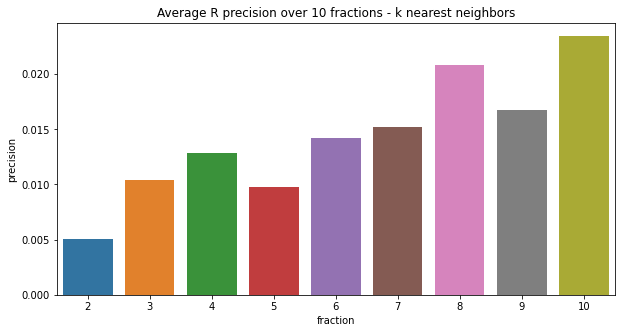

In [ ]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(result_mean.keys()), y=list(result_mean.values()))

_ = ax.set_title('Average R precision over 10 fractions - k nearest neighbors')

ax.set_ylabel('precision')
ax.set_xlabel('fraction')

plt.savefig('../../images/knn_average_R_precision.png', bbox_inches = 'tight')

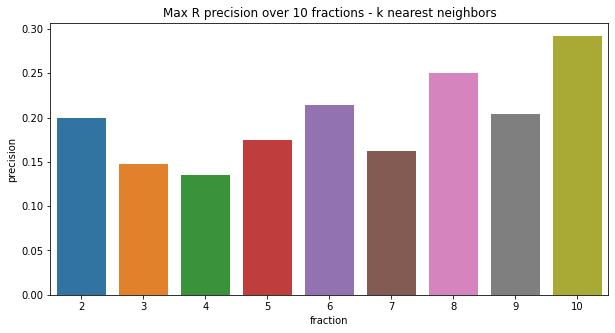

In [ ]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x=list(result_max.keys()), y=list(result_max.values()))

_ = ax.set_title('Max R precision over 10 fractions - k nearest neighbors')

ax.set_ylabel('precision')
ax.set_xlabel('fraction')

plt.savefig('../../images/knn_max_R_precision.png', bbox_inches = 'tight')

In [89]:
result = []

for keys in result_mean:
  result.append({'mean' : result_mean[keys]})

i = 0
for keys in result_max:
  result[i]['max'] = result_max[keys]
  result[i]['fraction'] = i + 2
  i = i + 1

result

[{'fraction': 2, 'max': 0.2, 'mean': 0.005095287825502538},
 {'fraction': 3, 'max': 0.14705882352941177, 'mean': 0.010446832839116257},
 {'fraction': 4, 'max': 0.13513513513513514, 'mean': 0.012818324424817876},
 {'fraction': 5, 'max': 0.175, 'mean': 0.009762789562880216},
 {'fraction': 6, 'max': 0.21428571428571427, 'mean': 0.014205176502289849},
 {'fraction': 7, 'max': 0.16279069767441862, 'mean': 0.015179354168911882},
 {'fraction': 8, 'max': 0.25, 'mean': 0.02083066114114872},
 {'fraction': 9, 'max': 0.20454545454545456, 'mean': 0.01678827430756467},
 {'fraction': 10, 'max': 0.29213483146067415, 'mean': 0.023466142355446175}]

In [90]:
df_result = pd.DataFrame(result)
df_result.to_csv('knn_result.csv', index = False)

**Nhận xét**: 

Kết quả **Average R precision** của model k-nearest-neighbors không được cao cho lắm và chạy không ổn định, giá trị chính xác của việc đề xuất bài hát dao động từ 0.005 - 0.025 với các fraction từ 2-10. Playlist tốt nhất đề xuất được là ở fraction 10, đề xuất đúng được gần 30%.